In [1]:
# Imports
import cv2
import numpy as np
import tensorflow as tf
import notMNIST_gen
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

In [2]:
def reformat_dataset(data):
  data = data / 255.
  return data.reshape((-1, data.shape[1], data.shape[1], 1)).astype(np.float32)

def reformat_labels(labels):
  char_labels = list(np.unique(labels)) #np.unique(train_labels.view('S1').reshape((labels.size, -1)))

  new_labels = np.ndarray(labels.shape, dtype=np.float32)
  for i in range(new_labels.shape[0]):
    for j in range(new_labels.shape[1]):
        curr_label = labels[i,j]
        if curr_label in char_labels:
            new_labels[i,j] = char_labels.index(curr_label)
  return (np.arange(len(char_labels)) == new_labels[:,:,None]).astype(np.float32)


In [3]:
def bbox_patch(subplot, bbox):
    '''
    Draw bounding boxes onto plot
    : subplot: plot to draw bounding box onto
    : bbox: array of shape [digits, x, y, width, height]
    '''
    for i in range(bbox.shape[0]):
        if np.sum(bbox[i]) > 0:
            subplot.add_patch(Rectangle((bbox[i,0], bbox[i, 1]), bbox[i, 2], 
                                        bbox[i, 3], fill=False))
def visual_check(samples, subplt_h=5):
    '''
    Plot randomly selected samples with their bounding boxes.
    : samples: a list of tuples, each tuple defined as (title, dataset, bbox)
    : subplt_h: number of cells in each subplot dimension, default of 5 results in 25 samples
    '''
    f, axarr = plt.subplots(subplt_h, subplt_h)     
    for r in range(subplt_h):
        for c in range(subplt_h):
            data = np.random.randint(0, 3)
            sample = np.random.randint(0,samples[data][1].shape[0])
            axarr[r, c].set_title(samples[data][0] + ' ' + str(sample))
            axarr[r, c].imshow(samples[data][1][sample])
            bbox_patch(axarr[r, c], samples[data][2][sample])

Starting
Download Complete
Extract Complete
Saving Complete
Data Dictionaries Built
Loaded Training set (100000, 64, 64) (100000, 5)
Loaded Validation set (10000, 64, 64) (10000, 5)
Loaded Test set (10000, 64, 64) (10000, 5)
Formatted Training set (100000, 64, 64, 1) (100000, 5)
Formatted Validation set (10000, 64, 64, 1) (10000, 5)
Formatted Test set (10000, 64, 64, 1) (10000, 5)


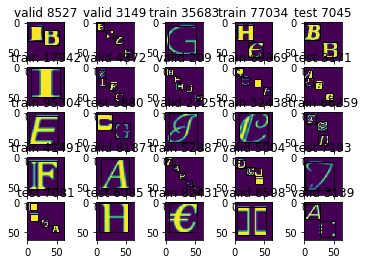

In [4]:
save = notMNIST_gen.gen_composite()
train_dataset = save['train_dataset']
train_bbox = save['train_bbox']
train_labels = save['train_labels']
valid_dataset = save['valid_dataset']
valid_bbox = save['valid_bbox']
valid_labels = save['valid_labels']
test_dataset = save['test_dataset']
test_bbox = save['test_bbox']
test_labels = save['test_labels']
del save  # Done with save, delete to free memory

data = [('train', train_dataset, train_bbox),
        ('test', test_dataset, test_bbox),
        ('valid', valid_dataset, valid_bbox)]

visual_check(data)

print('Loaded Training set', train_dataset.shape, train_labels.shape)
print('Loaded Validation set', valid_dataset.shape, valid_labels.shape)
print('Loaded Test set', test_dataset.shape, test_labels.shape)

train_dataset = reformat_dataset(train_dataset)
valid_dataset = reformat_dataset(valid_dataset)
test_dataset = reformat_dataset(test_dataset)

#train_labels = reformat_labels(train_labels)
#valid_labels = reformat_labels(valid_labels)
#test_labels = reformat_labels(test_labels)

print('Formatted Training set', train_dataset.shape, train_labels.shape)
print('Formatted Validation set', valid_dataset.shape, valid_labels.shape)
print('Formatted Test set', test_dataset.shape, test_labels.shape)

In [5]:
def digit_cropper(data, bboxes, labels):
    digit_string = list()
    label_string = list()
    digit_count = np.zeros(data.shape[0],dtype=np.float32)
    data_shape = data.shape
    for image in range(labels.shape[0]):
        for letter in range(labels.shape[1]):
            bbox = bboxes[image, letter]
            digit = np.zeros((64, 64, data_shape[3]), dtype=np.float32)
            if np.sum(bbox) > 0:
                curr_digit = cv2.resize(data[image, bbox[1]:bbox[1]+bbox[3], bbox[0]:bbox[0]+bbox[2], :], (64,64))
                digit[:,:,:] = curr_digit.reshape((64, 64, 1)).astype(np.float32)
                digit_count[image] += 1
#                curr_digit = data[image, bbox[1]:bbox[1]+bbox[3], bbox[0]:bbox[0]+bbox[2], :]
#                digit[bbox[1]:bbox[1]+bbox[3], bbox[0]:bbox[0]+bbox[2], :] = curr_digit
                digit_string.append(digit)
                label_string.append(labels[image, letter])

    label_string = np.vstack(label_string)
    label_string = reformat_labels(label_string)
    label_string = label_string.reshape((label_string.shape[0], label_string.shape[2]))
    digit_count = (np.arange(5) == digit_count[:,None]).astype(np.float32)
    digit_string = np.dstack(digit_string)
    digit_string = np.swapaxes(digit_string, 1, 2)
    digit_string = np.swapaxes(digit_string, 0, 1)
    digit_string = digit_string.reshape((-1, digit_string.shape[1], digit_string.shape[1], 1)).astype(np.float32)
    return digit_string, label_string, digit_count

In [6]:
train_digit_string, train_label_string, train_digit_count = digit_cropper(train_dataset, train_bbox, train_labels)
valid_digit_string, valid_label_string, train_digit_count = digit_cropper(valid_dataset, valid_bbox, valid_labels)
test_digit_string, test_label_string, train_digit_count = digit_cropper(test_dataset, test_bbox, test_labels)

train_digit_string = train_digit_string[:,:,:,:]
train_label_string = train_label_string[:,:]

valid_digit_string = valid_digit_string[:600,:,:,:]
valid_label_string = valid_label_string[:600,:]

test_digit_string = test_digit_string[:600,:,:,:]
test_label_string = test_label_string[:600,:]

In [7]:
print(train_digit_count.shape)

(10000, 5)


In [8]:
print('\t Full Dataset \t\t Full Labels \t Reduced Dataset \t Reduced Labels')
print('Train\t', train_dataset.shape,'\t', train_labels.shape,'\t', train_digit_string.shape,'\t', 
      train_label_string.shape)
print('Valid\t', valid_dataset.shape,'\t', valid_labels.shape,'\t', valid_digit_string.shape,'\t', 
      valid_label_string.shape)
print('Test\t', test_dataset.shape,'\t', test_labels.shape,'\t', test_digit_string.shape,'\t', 
      test_label_string.shape)

	 Full Dataset 		 Full Labels 	 Reduced Dataset 	 Reduced Labels
Train	 (100000, 64, 64, 1) 	 (100000, 5) 	 (200559, 64, 64, 1) 	 (200559, 10)
Valid	 (10000, 64, 64, 1) 	 (10000, 5) 	 (600, 64, 64, 1) 	 (600, 10)
Test	 (10000, 64, 64, 1) 	 (10000, 5) 	 (600, 64, 64, 1) 	 (600, 10)


In [9]:
def batch_input(image_shape):
    """
    Return a Tensor for a bach of image input
    : image_shape: Shape of the images
    : return: Tensor for image input.
    """
    x = tf.placeholder(tf.float32, shape=(None, image_shape[0], image_shape[1], 
                                             image_shape[2]), name='x')
    return x

def label_input(n_classes):
    """
    Return a Tensor for a batch of label input
    : n_classes: Number of classes
    : return: Tensor for label input.
    """
    y = tf.placeholder(tf.float32, shape=(None, n_classes), name='y')
    return y

def keep_prob_input():
    """
    Return a Tensor for keep probability
    : return: Tensor for keep probability.
    """
    keep_prob =  tf.placeholder(tf.float32, name='keep_prob')
    return keep_prob

def null_activation(batch):
    return batch

In [10]:
def conv_pool(batch, conv_patch=(1,1), conv_strides=(1,1), pool_patch=(1,1), pool_strides=(1,1), 
              outputs=1, conv_pad='SAME', pool_pad='SAME', weight_stddev=0.1, initial_bias=1.0, 
              activation=tf.nn.relu, keep_prob=1):

    weights = tf.Variable(tf.truncated_normal([conv_patch[0], conv_patch[1], 
                                               batch.get_shape().as_list()[3], 
                                               outputs], stddev=weight_stddev))
    bias = tf.Variable(tf.constant(initial_bias, shape=[outputs]))
    
    conv = tf.nn.conv2d(batch, weights, [1, conv_strides[0], conv_strides[1], 1], padding=conv_pad)
    conv = tf.add(conv, bias)
    conv = tf.nn.max_pool(conv, [1, pool_patch[0], pool_patch[1], 1], 
                          [1, pool_strides[0], pool_strides[1], 1], padding=pool_pad)
    conv = activation(conv)
    conv = tf.nn.dropout(conv, keep_prob)
    return conv

In [11]:
def full_conn(batch, outputs=128, keep_prob=1, weight_stddev=0.1, initial_bias=1.0, activation=tf.nn.relu):
    shape = batch.get_shape().as_list()
    weights = tf.Variable(tf.truncated_normal([shape[1], outputs], stddev=weight_stddev))
    bias = tf.Variable(tf.constant(initial_bias, shape=[outputs]))
    
    conn = tf.matmul(batch, weights)
    conn = tf.add(conn, bias)
    conn = activation(conn)
    conn = tf.nn.dropout(conn, keep_prob)
    return conn

In [12]:
def flatten(batch):
    shape = batch.get_shape().as_list()
    new_dim = 1
    for i in shape[1:]:
        new_dim *= i
    return tf.reshape(batch, (-1, new_dim))

In [13]:
def make_batch(data, labels, epoch, batch_size=16, batch_count=16):
    group_size = data.shape[0] // batch_count
    group_offset = batch_size*epoch
    for i in range(0, batch_count):
        batch_offset = i*group_size
        index = (batch_offset+group_offset) % data.shape[0]
        yield data[index:index+batch_size,:,:,:], labels[index:index+batch_size,:]

In [14]:
def train_neural_network(epoch,session, optimizer, data, labels, batch_size=16, batch_count=16, keep_probability=1.):
    """
    Optimize the session on a batch of images and labels
    : session: Current TensorFlow session
    : optimizer: TensorFlow optimizer function
    : keep_probability: keep probability
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    """
    for batch_data, batch_labels in make_batch(data, labels, epoch, batch_size, batch_count):
        feed_dict = {x:batch_data, y:batch_labels, keep_prob:keep_probability}
        fetches = [optimizer]
        session.run(fetches, feed_dict=feed_dict)

In [15]:
def print_stats(session, name, data, labels, cost, accuracy, batch_size=100, batch_count=10):
    """
    Print information about loss and validation accuracy
    : session: Current TensorFlow session
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    : cost: TensorFlow cost function
    : accuracy: TensorFlow accuracy function
    """
    loss = list()
    acc = list()
    for batch_data, batch_labels in make_batch(data, labels, batch_size, batch_count):
        feed_dict = {x:batch_data, y:batch_labels, keep_prob:1}
        batch_loss, batch_acc = session.run([cost, accuracy], feed_dict=feed_dict)
        loss.append(batch_loss)
        acc.append(batch_acc)
    print('\t'+name+': loss {:6.4f} and accuracy {:5.2f}%'.format(np.mean(loss), np.mean(acc)*100), end='\t')

In [35]:
def conv_net(batch, keep_prob=1):
    print(batch.get_shape().as_list())
    model = conv_pool(batch, outputs=32, conv_patch=(5,5), conv_strides=(2,2), pool_patch=(2,2), pool_strides=(1,1))
    print(model.get_shape().as_list())
    model = conv_pool(model, outputs=128, conv_patch=(5,5), conv_strides=(2,2), pool_patch=(2,2), pool_strides=(1,1))
    print(model.get_shape().as_list())
    model = conv_pool(model, outputs=512, conv_patch=(5,5), conv_strides=(2,2), pool_patch=(2,2), pool_strides=(1,1))
    print(model.get_shape().as_list())
    model = conv_pool(model, outputs=1024, conv_patch=(5,5), conv_strides=(2,2), pool_patch=(1,1), pool_strides=(1,1))
    print(model.get_shape().as_list())
    model = conv_pool(model, outputs=1024, conv_patch=(5,5), conv_strides=(2,2), pool_patch=(1,1), pool_strides=(1,1))
    print(model.get_shape().as_list())

    model = flatten(model)

#    model = full_conn(model, 512, keep_prob)
#    model = full_conn(model, 256, keep_prob)
    model = full_conn(model, 128, keep_prob)
    model = full_conn(model, 10, activation=null_activation)
    return model

In [36]:
def count_digits(model, keep_prob=1):
        return full_conn(model, 5, activation=null_activation)

In [37]:
# Remove previous weights, bias, inputs, etc..
tf.reset_default_graph()

# Inputs
x = batch_input((64, 64, 1))
y = label_input(10)
keep_prob = keep_prob_input()

# Model
logits = conv_net(x, keep_prob)
#digit_num = count_digits(conv_model, keep_prob)

# Name logits Tensor, so that is can be loaded from disk after training
logits = tf.identity(logits, name='digit_logits')

# Loss and Optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
#cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=digit_num, labels=y))
optimizer = tf.train.AdamOptimizer().minimize(cost)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

[None, 64, 64, 1]
[None, 32, 32, 32]
[None, 16, 16, 128]
[None, 8, 8, 512]
[None, 4, 4, 1024]
[None, 2, 2, 1024]


In [38]:
# TODO: Tune Parameters
epochs = 40
batch_size = 128
batch_count = 100
keep_probability = 0.5

In [ ]:
save_model_path = './single_digit_classifier.tfm'
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        train_neural_network(epoch, sess, optimizer, train_digit_string, train_label_string, 
                             batch_size, batch_count, keep_probability)
        print('Epoch {:>2}:  '.format(epoch+1), end='')
        print_stats(sess, 'Train', train_digit_string, train_label_string, cost, accuracy, batch_size, batch_count)
        print_stats(sess, 'Valid', valid_digit_string, valid_label_string, cost, accuracy, batch_size, batch_count)
        print('')
    print_stats(sess, 'test', test_digit_string, test_label_string, cost, accuracy, batch_size, batch_count)

    # Save Model
    saver = tf.train.Saver()
    save_path = saver.save(sess, save_model_path)

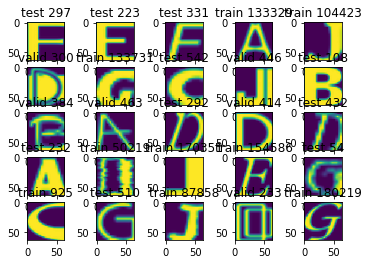

In [28]:
samples = [('train', train_digit_string.reshape((train_digit_string.shape[0], 64, 64)), train_bbox),
        ('test', test_digit_string.reshape((test_digit_string.shape[0], 64, 64)), test_bbox),
        ('valid', valid_digit_string.reshape((valid_digit_string.shape[0], 64, 64)), valid_bbox)]

subplt_h = 5
f, axarr = plt.subplots(subplt_h, subplt_h)     
for r in range(subplt_h):
    for c in range(subplt_h):
        data = np.random.randint(0, 3)
        sample = np.random.randint(0,samples[data][1].shape[0])
        axarr[r, c].set_title(samples[data][0] + ' ' + str(sample))
        axarr[r, c].imshow(samples[data][1][sample])

### Fully Train the Model
Now that you got a good accuracy with a single CIFAR-10 batch, try it with all five batches.

In [20]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
save_model_path = './image_classification'

print('Training...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        # Loop over all batches
        n_batches = 5
        for batch_i in range(1, n_batches + 1):
            for batch_features, batch_labels in helper.load_preprocess_training_batch(batch_i, batch_size):
                train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
            print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
            print_stats(sess, batch_features, batch_labels, cost, accuracy)
            
    # Save Model
    saver = tf.train.Saver()
    save_path = saver.save(sess, save_model_path)

Training...


NameError: name 'helper' is not defined

# Checkpoint
The model has been saved to disk.
## Test Model
Test your model against the test dataset.  This will be your final accuracy. You should have an accuracy greater than 50%. If you don't, keep tweaking the model architecture and parameters.

In [ ]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import tensorflow as tf
import pickle
import random

# Set batch size if not already set
try:
    if batch_size:
        pass
except NameError:
    batch_size = 64

save_model_path = './image_classification'
n_samples = 4
top_n_predictions = 3

def test_model():
    """
    Test the saved model against the test dataset
    """

#    test_features, test_labels = pickle.load(open('preprocess_training.p', mode='rb'))
    loaded_graph = tf.Graph()

    with tf.Session(graph=loaded_graph) as sess:
        # Load model
        loader = tf.train.import_meta_graph(save_model_path + '.meta')
        loader.restore(sess, save_model_path)

        # Get Tensors from loaded model
        loaded_x = loaded_graph.get_tensor_by_name('x:0')
        loaded_y = loaded_graph.get_tensor_by_name('y:0')
        loaded_keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
        loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
        loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')
        
        # Get accuracy in batches for memory limitations
        test_batch_acc_total = 0
        test_batch_count = 0
        
        for train_feature_batch, train_label_batch in helper.batch_features_labels(test_features, test_labels, batch_size):
            test_batch_acc_total += sess.run(
                loaded_acc,
                feed_dict={loaded_x: train_feature_batch, loaded_y: train_label_batch, loaded_keep_prob: 1.0})
            test_batch_count += 1

        print('Testing Accuracy: {}\n'.format(test_batch_acc_total/test_batch_count))

        # Print Random Samples
        random_test_features, random_test_labels = tuple(zip(*random.sample(list(zip(test_features, test_labels)), n_samples)))
        random_test_predictions = sess.run(
            tf.nn.top_k(tf.nn.softmax(loaded_logits), top_n_predictions),
            feed_dict={loaded_x: random_test_features, loaded_y: random_test_labels, loaded_keep_prob: 1.0})
        helper.display_image_predictions(random_test_features, random_test_labels, random_test_predictions)


test_model()